### Preparation
Install azureml-core so that you can create resources locally first before heading to the cloud to deploy your model. <br>
Run this line in Anaconda Prompt:

```pip install azureml-core```

Download script: <br>
https://github.com/Azure/aml-template/blob/master/code/deploy/score.py

In [2]:
# pip install azureml-core

In [1]:
# import Workspace to create a workspace for your model
from azureml.core import Workspace

### Get the config.json file from your workspace in the Azure cloud first

In [4]:
# connect to cloud using your config in same folder as this notebook
# find config file in azure > Home > Machine learning > <resource_group_name> > Overview > Download config.json
ws = Workspace.from_config(path="config.json")

Performing interactive authentication. Please follow the instructions on the terminal.


Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"


You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.


In [5]:
# doublecheck to see your workspace details
ws

Workspace.create(name='UpLevelDeploymentJackie', subscription_id='dfc52a0b-51a6-445d-843b-77de13e172cc', resource_group='UpLevelDeploymentJackie')

### Train a model locally
We'll use the Boston housing dataset to train a model locally first before uploading it to the cloud.

In [3]:
# train a model locally
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
# load the boston housing data
from sklearn.datasets import load_boston

boston_dataset = load_boston()
boston_dataset

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [5]:
print(boston_dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
data = pd.DataFrame(boston_dataset.data)
target = pd.DataFrame(boston_dataset.target)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target)

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

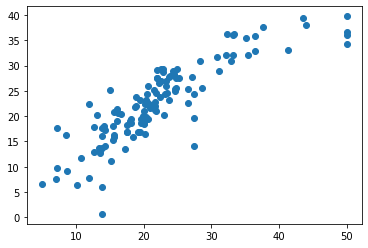

In [9]:
lr_pred = lr.predict(X_test)

plt.scatter(y_test, lr_pred)

### Pickle your model using joblib

In [16]:
import joblib

# make a new folder, outputs
os.makedirs("outputs", exist_ok = True)

# serialise regression model into pickle file
joblib.dump(value=lr, filename='outputs/housing_lr.pkl')

['outputs/housing_lr.pkl']

### Registering the pickled model for deployment
You'll need to register your model in your workspace so you can deploy the model.

In [17]:
from azureml.core.model import Model

model = Model.register(workspace=ws,
                       model_path="./outputs/housing_lr.pkl",
                       model_name="housing_lr_model_jackie")

# if successful, you will see model in Azure > Home > Models

Registering model housing_lr_model_jackie


### Create the environment file
We'll need to deploy the model using the same conditions as what we used.

As such, we'll create a YAML file containing our libraries / dependencies.

In [19]:
# create environment file
from azureml.core.conda_dependencies import CondaDependencies

In [20]:
myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")
myenv.add_conda_package("joblib")
myenv.add_conda_package("numpy")

with open("myenv.yml", "w") as f:
    f.write(myenv.serialize_to_string())

### Head to the Azure cloud platform next to deploy the model!